# Car Damage Inspection Using Deep Learning

## Business Problem

Whenever something bad(damage) happens to our car, the first action most of us take is to call our insurance company and tell them what has happened. We then have to wait for an agent from the insurance company to come and inspect the car physically, which usually involves taking pictures of the damaged areas. The agent then forwards his/her findings to the insurance company for processing. This process of inspection usually takes weeks and sometimes months, which results in claim delay. 

## Linking the Problem to Deep Learning

With the power of deep learning, we can utilize Convolution Neural Network(CNN) achitecture along with transfer learning to help speed up the process of car inspection. Convolution neural network allows us to be able to build a model that accepts image as input data, learn from the image and outputs a predicted label/category which the image belongs. With this, we can build a system that allow users to submit image of thier damaged car, passes the image through multiple checks and give report on the location of the damage and how severe the damage is. The system will be able to predict if the location of the damage is on the front, rare or side of the car and if the damage is minor, moderate or severe. This type of system will enable insurance companies to receive quick report on a customers situation, thereby speeding the the process of insurance claim.

**Transfer Learning - VGG16**

Building a Convolution Neural Network model from scratch usually requires high system hardware configuration and a very large training data set. Transfer learning allows us to be able to make use of the weights of already trained models. VGG16 is a convolution neural network architecture that has been trained to classify images of 1000 different labels/categories including cars, with 92.7% accuracy. For this project, we will be using the VGG16 to detect images(car or not) and to extract features, which will be used to build different classification models.

## Model architecture and Pipeline

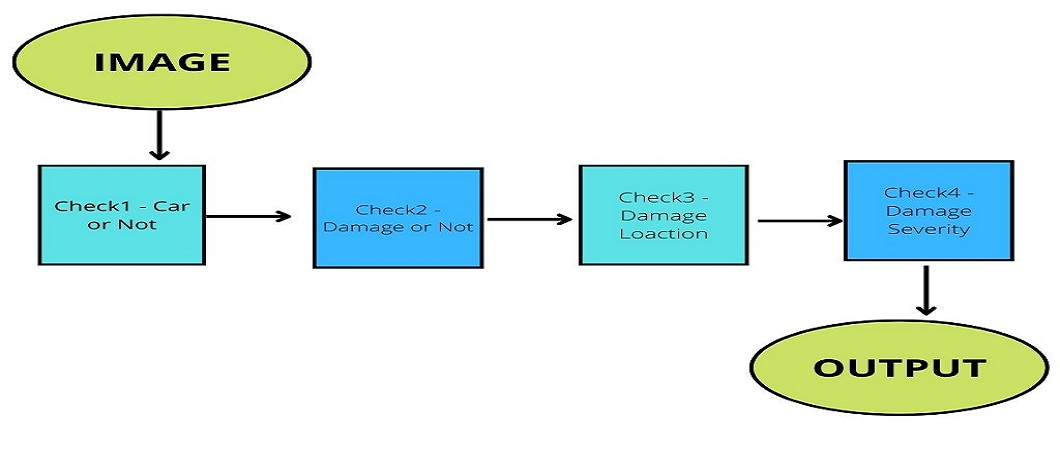

1. User submit image.
2. First Check - checks if image is of a car or not(using VGG16).
3. Second Check - checks if car is damaged or not(VGG16 for feature extraction, Logistic Regression for building classification model)
4. Third Check - checks for the location of damage(VGG16 for feature extraction, Random Forest for building classification model)

5. Fourth Check - checks for the severity of damage(VGG16 for feature extraction, Random Forest for building classification model)

## Performance Metrics

Accuracy, Precision and recall will be use to judge the performance of our models. These metrics are canculated using the Confusion matrix.

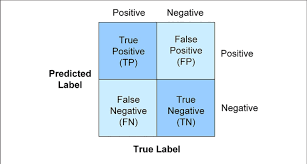

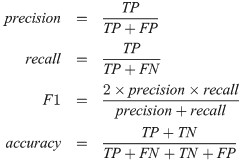

## Data Scource

- **kaggle:** https://www.kaggle.com/anujms/car-damage-detection 
This data set contains 2300 images damaged and normal cars


- **Bing Image downloader:** python library for downloading images from bring.com.


### Load Libraries

In [42]:
import os
import json
import glob
import time
import h5py
import random
import datetime
import warnings
import numpy as np
import seaborn as sn
from PIL import Image
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from keras.models import Model
from bing_image_downloader import downloader
from IPython.display import clear_output
from keras.utils.data_utils import get_file
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from keras.utils import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input
%matplotlib inline

## 1.0 Introduction to vgg16

We first show how the default vgg16 model can be used predict an image.

In [2]:
#download vgg16 model
vgg16 = VGG16(weights='imagenet')

In [3]:
#Save vgg16 model
vgg16.save('vgg16.h5')

**Predict Sample Image**

We will now try to detect the image displayed below using the downloaded VGG16 model

In [4]:
#function to display image
def display_img(img_path):
    sample_img = load_img(img_path)
    img_array = img_to_array(sample_img)
    plot = plt.imshow(img_array/255.)
    plt.axis('off')
    return plot

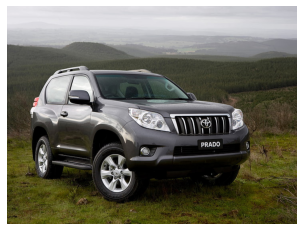

In [5]:
display_img('C:/Users/Admin/image2.jpg')

In [6]:
#Function to preprocess image into shape acceptable by VGG16
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [7]:
#preprocess and predict image category
y = preprocess_image('C:/Users/Admin/image2.jpg')
preds = vgg16.predict(y)

1/1 [==============================] - 1s 1s/step


Since VGG16 outputs 1000 possible predictions base on probabilty between 0 and 1, we can extract the labels with top probablities for the image we want to predict. imagenet_class_index.json contains the indices and label of the 1000 labels that VGG16 was trained with, we can use this file to match the label VGG16 has predicted for the image we want to predict.

In [8]:
class_index = None

#Downloaded from: 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
class_index_path = 'imagenet_class_index.json'

def get_predictions(preds,top=5):
    global class_index
    
    #load json file
    class_index = json.load(open(class_index_path))
    
    #top5 predictions
    results = []
    for i in preds:
        top_five = i.argsort()[-top:][::-1]
        result = [tuple(class_index[str(x)]) + (i[x],) for x in top_five]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [9]:
print(get_predictions(preds, top=5))

[[('n03594945', 'jeep', 0.3518683), ('n03770679', 'minivan', 0.30609852), ('n03930630', 'pickup', 0.12262269), ('n02814533', 'beach_wagon', 0.05325712), ('n03100240', 'convertible', 0.044236083)]]


The above result is the top 5 prediction and probability of the sample image. We can see that the model has predicted that the image is a Jeep with 35% probability or a minivan with 30% probability or a pickup with 12% probability.

## 1.1 First Check - Car or not

Our main objective is to build a model that is capable of detecting if an image is of a car or not. To achieve this, we pass 920 images of cars to the vgg16 model and obtain the top 5 predicted labels and probabilities for each image. When an image is passed and the predicted label does not belong to any of the top 5 labels obtained during training, the model will not classify the image as a car.

### 1.1.0 Load and Explore Data

Number of Car Image is: 920


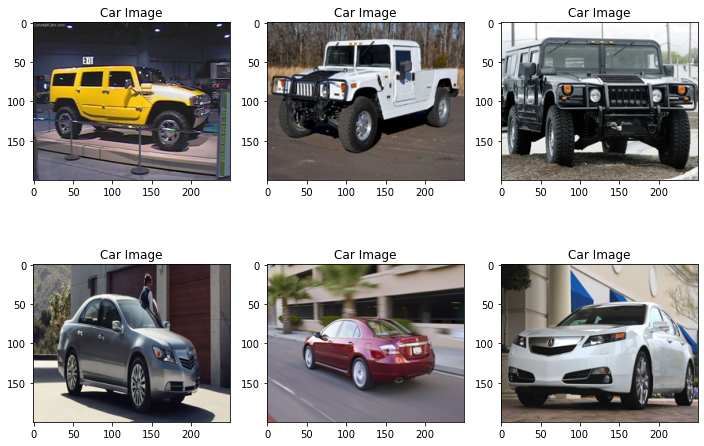

In [10]:
car_img_path = 'C:/Users/Admin/cars/'
print('Number of Car Image is:', len(os.listdir(car_img_path)))
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.grid"] = False
for i in range(6):
    car_img = os.listdir(car_img_path)[i]
    car_img_address = car_img_path+car_img
    car_load = Image.open(car_img_address)
    car_resize = car_load.resize((250, 200))
    ax = plt.subplot(int(6/2),int(6/2),i+1)
    plt.tight_layout()
    plt.imshow(car_resize)
    plt.title('Car Image')
    

In [11]:
from collections import Counter, defaultdict
import pickle as pk

### 1.1.1 Prediction

In [36]:
#function to obtain top 5 predicted label for each image

def get_car_labels():
    d = defaultdict(float)
    img_list = os.listdir('C:/Users/Admin/cars')
    for i, img_path in enumerate(img_list):
        img = preprocess_image('C:/Users/Admin/cars/'+img_path)
        predt = vgg16.predict(img) #predict label for each car image
        top = get_predictions(predt, top=5) #get top 5 labels for each car image
        clear_output(wait=True)
        for j in top[0]:
            d[j[0:2]] += j[2]
    return Counter(d)

In [37]:
label_counter = get_car_labels()

1/1 [==============================] - 0s 360ms/step


In [179]:
#save labels
#with open('label_counter.pk', 'wb') as f:
#    pk.dump(label_counter,f,-1)

In [180]:
#load saved label_counter
#with open('label_counter.pk', 'rb') as f:
#    label_counter = pk.load(f)

In [38]:
#extract the most common label
label_list = [i for i, j in label_counter.most_common()[:25]]

In [39]:
label_list[:10]

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n03594945', 'jeep'),
 ('n03769881', 'minibus'),
 ('n04461696', 'tow_truck')]

The label_list above contains 25 most common predictions made by the model. The below code will take an image, process the image, make prediction and check if the prediction is present in the label list.

In [54]:
#function to predict image
def car_or_not(image_path, label_list):
    img = preprocess_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print('Checking if this is a car picture, please wait...\n')
    for j in top[0]:
        if j[0:2] in label_list:
            print('Prediction:', j[1:2])
            return 'Complete'
    return "Please be sure to have uploaded the picture of your car, try a different angle or lighting"

### 1.1.2 Model Test

Now we test the model with a car image and another image which is not of a car

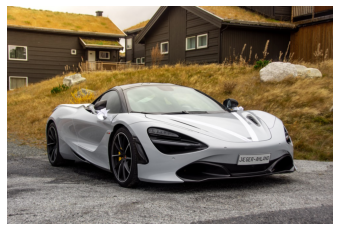

In [55]:
display_img('C:/Users/Admin/image5.jpg')

In [56]:
car_or_not('C:/Users/Admin/image5.jpg', label_list)

1/1 [==============================] - 0s 379ms/step
Checking if this is a car picture, please wait...

Prediction: ('sports_car',)


'Complete'

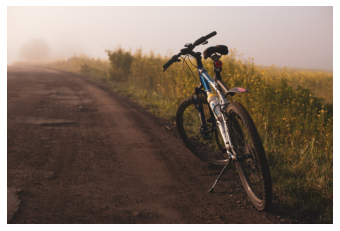

In [57]:
display_img('C:/Users/Admin/img1.jfif')

In [58]:
car_or_not('C:/Users/Admin/img1.jfif', label_list)

1/1 [==============================] - 0s 378ms/step
Checking if this is a car picture, please wait...



'Please be sure to have uploaded the picture of your car, try a different angle or lighting'

- We can see that our model was able to predict the first image as a car and the second image as not a car

## 2.0 Second Check - Damage or not

We will now build a model to detect if the car is damaged or not. We will use vgg16 to extract features from two categories of car images(damage and normal), then use logistic regression to build a classification model that will determine if the car is damaged or normal using the extracted features.

### 2.1 Load and Explore Data

In [59]:
train_norm_path ='C:/Users/Admin/cardata1/training/01-normal/'
train_dam_path ='C:/Users/Admin/cardata1/training/00-damage/'
lbl_dir = 'C:/Users/Admin/cardata1/training/'
lbl = os.listdir(lbl_dir)
def display_samples1(number, normal = True):
    plt.figure(figsize=(10,10))
    if normal == True:
        for i in range(number):
            normal_img = os.listdir(train_norm_path)[i]
            normal_img_address = train_norm_path+normal_img
            normal_load = Image.open(normal_img_address)
            normal_resize = normal_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.tight_layout()
            plt.imshow(normal_resize)
            plt.title('Normal Car')
    else:
        for i in range(number):
            dam_img = os.listdir(train_dam_path)[i]
            dam_img_address = train_dam_path+dam_img
            dam_load = Image.open(dam_img_address)
            dam_resize = dam_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.imshow(dam_resize)
            plt.title('Damaged Car')
    plt.axis('off')

**Plot Sample Images**

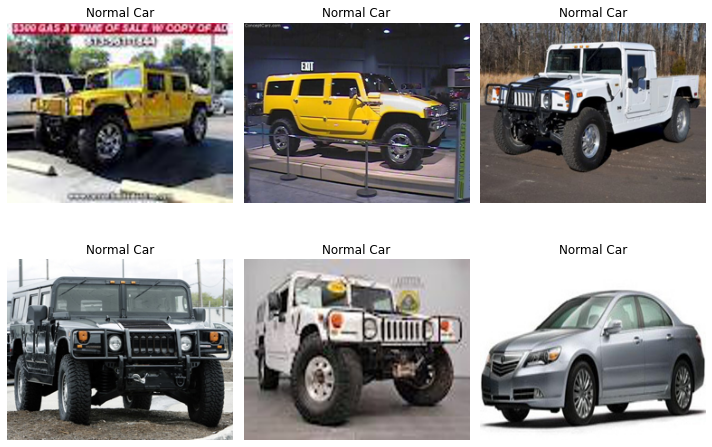

In [60]:
#show No damage images
display_samples1(6)

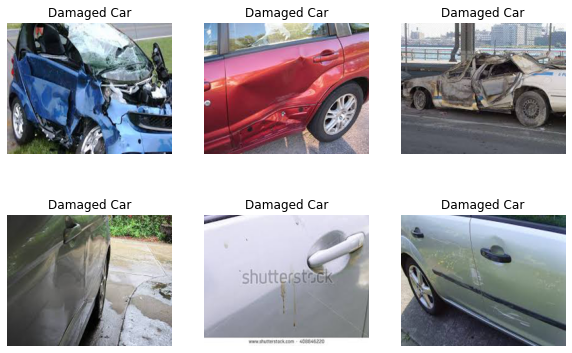

In [61]:
#show damaged images
display_samples1(6,False)

**Bar Plot**

In [62]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [63]:
#function for ploting bar graph
def bar_plot(img_dir):
    lb = []
    for l in lbl:
        path = os.path.join(img_dir, l)
        for i in os.listdir(path):
            lb.append(l)
    plt.figure(figsize=(8,5))
    sn.set_style('whitegrid')
    sn.countplot(lb)
    print('Total Number of Images:', len(lb))

Total Number of Images: 2254
Number of Normal Car Images: 1135
Number of Damaged Car Images: 1119


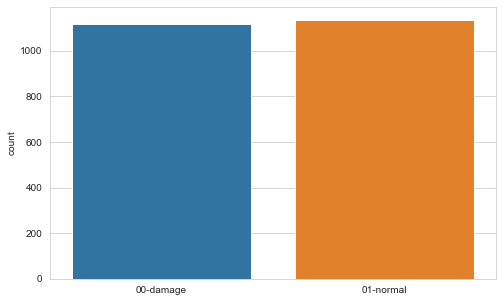

In [64]:
bar_plot(lbl_dir)

print('Number of Normal Car Images:', len(os.listdir(train_norm_path)))
print('Number of Damaged Car Images:', len(os.listdir(train_dam_path)))

In [65]:
#define parameters to be used 
config = {
    'model': 'vgg16',
    'weights': 'imagenet',
    'include_top': False,
    'train_path': 'C:/Users/Admin/cardata1/training',
    #'test_path': 'C:/Users/Admin/cardata1/test',
    'features_path': 'C:/Users/Admin/car-damage-params/features.h5',
    'labels_path': 'C:/Users/Admin/car-damage-params/labels.h5',
    'results': 'C:/Users/Admin/car-damage-params/results.txt',
    'classifier_path': 'C:/Users/Admin/car-damage-params/classifier.pickle',
    'model_path': 'C:/Users/Admin/car-damage-params/model',
    'test_size': 0.20,
    'seed': 9,
    'num_classes': 2
}

In [66]:
#create variables
model_name = config['model']
weights = config['weights']
include_top = config['include_top']
train_path = config['train_path']
features_path = config['features_path']
labels_path = config['labels_path']
results = config['results']
model_path = config['model_path']
test_size = config['test_size']
classifier_path = config['classifier_path']
seed = config['seed']

### 2.1 VGG16 For Feature Extraction

To extract the features, we excluse the dense layers and only make use of the convoluton layers.

In [67]:
#load vgg16 excluding the dense layer
warnings.simplefilter(action='ignore', category=FutureWarning)

if model_name == 'vgg16':
    base_model = VGG16(weights=weights)
    model = Model(base_model.input, base_model.get_layer('fc1').output) #get the 16 conv layers and full conv layer 1
    image_size = (224, 224)
else:
    model = None
print('Successfully loaded base model and model')
    

Successfully loaded base model and model


In [68]:
#load image, preprocess and extract features using vgg16
train_labels = os.listdir(train_path)

le = LabelEncoder()
le.fit([t1 for t1 in train_labels])

features = []
labels = []

count = 1

for i, label in enumerate(train_labels):
    cur_path = train_path + '/' + label
    count = 1
    for image_path in glob.glob(cur_path + '/*.jpg'):
        img = load_img(image_path, target_size = image_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        clear_output(wait=True)
        
    print('Completed label - '+ label)

#Encode labels
le = LabelEncoder()
le_labels = le.fit_transform(labels)

Completed label - 01-normal


**Models Summary**

In [69]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We can see that all the convolution layers and dense layers are present

In [70]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We can see that the our model does not have the second fully connected layer and the prediction layer. We have only made use of the conv layers to extract features.

**Save Features and Labels**

In [71]:
#save extracted features and labels

h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))
h5f_data.close()
h5f_label.close()

#save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + '.json', 'w') as json_file:
    json_file.write(model_json)
    
#save weights
model.save_weights(model_path + str(test_size) + '.h5')
print('Features, Labels, Model and Weights saved..')

end = time.time()
#print('End time - {}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M')))

Features, Labels, Model and Weights saved..


### 2.2  Logistic Regression

We are using Logistic regression because its one of the most efficient algorithm suitable for binary classification(classification of two classes).

In [72]:
#load features and labels
h5f_data = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_1']
labels_string = h5f_label['dataset_1']

features = np.array(features_string)
labels = np.array(labels_string)
h5f_data.close()
h5f_data.close()

In [73]:
#split data to train and test

(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                 np.array(labels),
                                                                 test_size=test_size,
                                                                 random_state=seed)

print('Training Data images: {}'.format(trainData.shape[0]))
print('Testing Data images: {}'.format(testData.shape[0]))
print('*'*30)
print('Training Labels: {}'.format(trainLabels.shape[0]))
print('Testing Labels: {}'.format(testLabels.shape[0]))

Training Data images: 1803
Testing Data images: 451
******************************
Training Labels: 1803
Testing Labels: 451


In [74]:
#train model
LRmodel = LogisticRegression(random_state=seed, max_iter=1000)
LRmodel.fit(trainData, trainLabels)

LogisticRegression(max_iter=1000, random_state=9)

In [75]:
#predict using testdata
LRpred = LRmodel.predict(testData)

In [76]:
#model evaluation
accuracy = metrics.accuracy_score(testLabels, LRpred)
print('Accuracy: ', accuracy)

Accuracy:  0.917960088691796


In [77]:
#save model
pk.dump(LRmodel, open(classifier_path, 'wb'))

In [78]:
print(metrics.classification_report(testLabels, LRpred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       228
           1       0.93      0.90      0.92       223

    accuracy                           0.92       451
   macro avg       0.92      0.92      0.92       451
weighted avg       0.92      0.92      0.92       451



<Figure size 432x288 with 0 Axes>

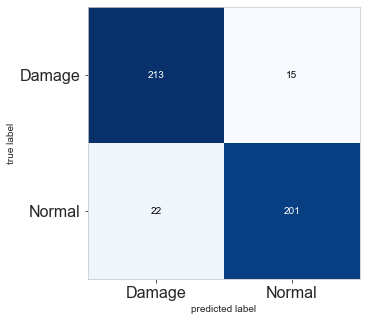

In [79]:
#confusion matrix
confmatrix  = metrics.confusion_matrix(testLabels, LRpred)
plt.figure()
plot_confusion_matrix(confmatrix,figsize=(8,5), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Damage','Normal'], fontsize=16)
plt.yticks(range(2), ['Damage','Normal'], fontsize=16)
plt.show()

### 2.3 Model Testing

Now we test the model with a damaged car image and a normal car image

**2.3.0 Load Logistic Regression Model**

In [80]:
#load model
classifier = pk.load(open(config['classifier_path'], 'rb'))

#read,preprocess and classify image
def damaged_or_not(image_path):    
    img = load_img(image_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    label_check1 = ['Car is Damaged', 'Car is not Damaged']
    return label_check1[preds[0]]

**2.3.1 Predictions**

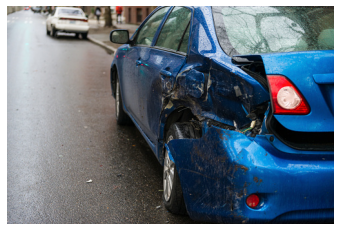

In [81]:
#damaged car
display_img('C:/Users/Admin/damaged.jpg')

In [82]:
#prediction
damaged_or_not('C:/Users/Admin/damaged.jpg')

1/1 [==============================] - 0s 248ms/step


'Car is Damaged'

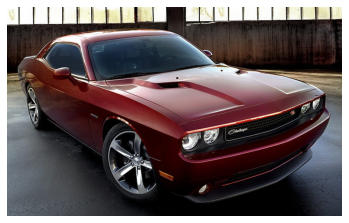

In [83]:
#Normal car
display_img('C:/Users/Admin/Normal.jpg')

In [84]:
#prediction
damaged_or_not('C:/Users/Admin/Normal.jpg')

1/1 [==============================] - 0s 244ms/step


'Car is not Damaged'

This model will be used when the image has passed the first check

## 3.0 Third Check - Damage location

Following the previous steps, we will now build a model that will detect the side of the car in which the damage has occured. We will be using vgg16 to extract faetures and performe the classification using logistic regression.

### 3.1 Load and Explore Data

In [85]:
train_front_path ='C:/Users/Admin/carFRSdata/training/00-front/'
train_rare_path ='C:/Users/Admin/carFRSdata/training/01-rear/'
train_side_path ='C:/Users/Admin/carFRSdata/training/02-side/'
lbl_dir1 = 'C:/Users/Admin/carFRSdata/training/'
lbl = os.listdir(lbl_dir1)
def display_samples2(number, label):
    plt.figure(figsize=(10,10))
    if label == 'front':
        for i in range(number):
            front_img = os.listdir(train_front_path)[i]
            front_img_address = train_front_path+front_img
            front_load = Image.open(front_img_address)
            front_resize = front_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.tight_layout()
            plt.imshow(front_resize)
            plt.title('Front Damage')
    elif label == 'rare':
        for i in range(number):
            rare_img = os.listdir(train_rare_path)[i]
            rare_img_address = train_rare_path+rare_img
            rare_load = Image.open(rare_img_address)
            rare_resize = rare_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.imshow(rare_resize)
            plt.title('Rare Damage')
    else:
        for i in range(number):
            side_img = os.listdir(train_side_path)[i]
            side_img_address = train_side_path+side_img
            side_load = Image.open(side_img_address)
            side_resize = side_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.imshow(side_resize)
            plt.title('Side Damage')
    plt.axis('off')

**Plot Sample Images**

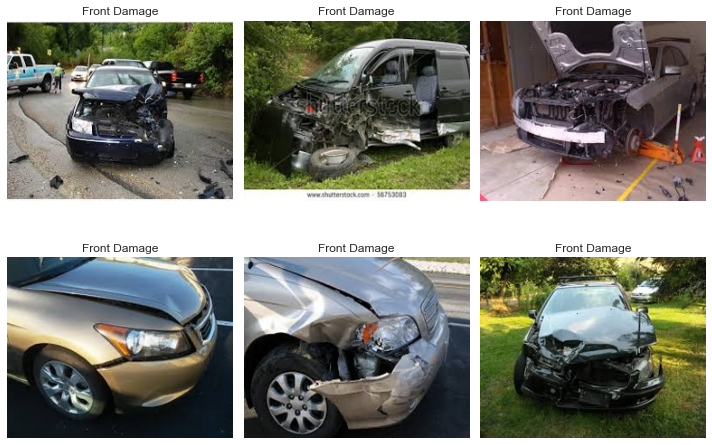

In [86]:
#display front damage images
display_samples2(6, label = 'front')

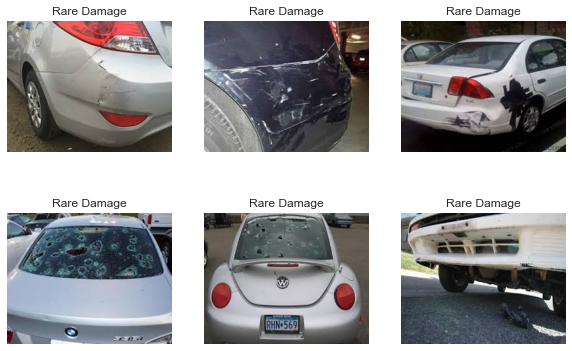

In [87]:
#display rare damage images
display_samples2(6, label = 'rare')

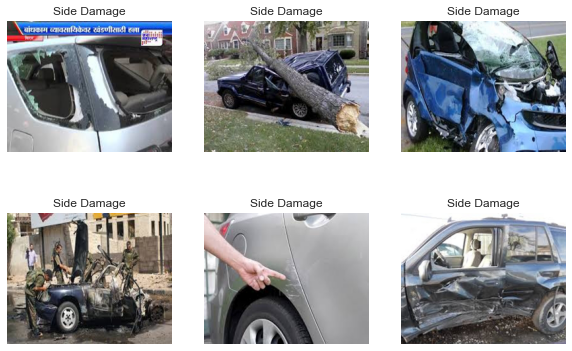

In [88]:
#display side damage images
display_samples2(6, label = 'side')

**Bar Plot**

Total Number of Images: 1373
Number of Front damaged Car Images : 490
Number of Rare damaged Car Images: 437
Number of Side damaged Car Images: 446


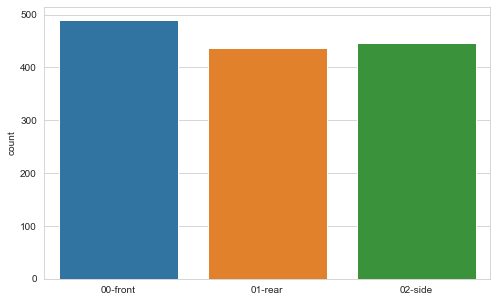

In [89]:
bar_plot(lbl_dir1)

print('Number of Front damaged Car Images :', len(os.listdir(train_front_path)))
print('Number of Rare damaged Car Images:', len(os.listdir(train_rare_path)))
print('Number of Side damaged Car Images:', len(os.listdir(train_side_path)))

**Variable Declaration**

In [90]:
config2 = {
    'model': 'vgg16',
    'weights': 'imagenet',
    'include_top': False,
    'train_path': 'C:/Users/Admin/carFRSdata/training',
    'test_path': 'C:/Users/Admin/carFRSdata/test',
    'features_path': 'C:/Users/Admin/car-FRS-params/features.h5',
    'labels_path': 'C:/Users/Admin/car-FRS-params/labels.h5',
    'results': 'C:/Users/Admin/car-FRS-params/results.txt',
    'classifier_path': 'C:/Users/Admin/car-FRS-params/classifier.pickle',
    'model_path': 'C:/Users/Admin/car-FRS-params/model',
    'test_size': 0.20,
    'seed': 9
}

In [91]:
model_name = config2['model']
weights = config2['weights']
include_top = config2['include_top']
train_path = config2['train_path']
features_path = config2['features_path']
labels_path = config2['labels_path']
results = config2['results']
model_path = config2['model_path']
test_size = config2['test_size']
classifier_path = config2['classifier_path']
seed = config2['seed']

In [92]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [93]:
if model_name == 'vgg16':
    base_model = VGG16(weights=weights)
    model = Model(base_model.input, base_model.get_layer('fc1').output) #get the 16 conv layers and full conv layer 1
    image_size = (224, 224)
else:
    model = None
print('Successfully loaded base model and model')
    

Successfully loaded base model and model


**Feature Exctraction**

In [94]:
train_labels = os.listdir(train_path)

le = LabelEncoder()
le.fit([t1 for t1 in train_labels])

features = []
labels = []

count = 1

for i, label in enumerate(train_labels):
    cur_path = train_path + '/' + label
    count = 1
    for image_path in glob.glob(cur_path + '/*.jpg'):
        img = load_img(image_path, target_size = image_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        clear_output(wait=True)
    print('Completed label - '+ label)

#Encode labels
le = LabelEncoder()
le_labels = le.fit_transform(labels)


Completed label - 02-side


**Save Features and Labels**

In [95]:
#save extracted features and labels

h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_2', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_2', data=np.array(le_labels))
h5f_data.close()
h5f_label.close()

#save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + '.json', 'w') as json_file:
    json_file.write(model_json)
    
#save weights
model.save_weights(model_path + str(test_size) + '.h5')
print('Features, Labels, Model and Weights saved..')

end = time.time()
#print('End time - {}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M')))

Features, Labels, Model and Weights saved..


## 3.1 Random Forest

We are using random forest because it is more suitable for multi-classification problems.

In [96]:
#load features and labels
h5f_data = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_2']
labels_string = h5f_label['dataset_2']

features = np.array(features_string)
labels = np.array(labels_string)
h5f_data.close()
h5f_data.close()

In [97]:
#split data to train and test

(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                 np.array(labels),
                                                                 test_size=test_size,
                                                                 random_state=seed)

print('Training Data images: {}'.format(trainData.shape[0]))
print('Testing Data images: {}'.format(testData.shape[0]))
print('*'*30)
print('Training Labels: {}'.format(trainLabels.shape[0]))
print('Testing Labels: {}'.format(testLabels.shape[0]))

Training Data images: 1098
Testing Data images: 275
******************************
Training Labels: 1098
Testing Labels: 275


In [98]:
#train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(trainData, trainLabels)

RandomForestClassifier(random_state=0)

In [99]:
#test model
rf_modelpred = rf_model.predict(testData)

In [100]:
#model evaluation
accuracy = metrics.accuracy_score(testLabels, rf_modelpred)
print('Accuracy: ', accuracy)

Accuracy:  0.7127272727272728


In [101]:
pk.dump(rf_model, open(classifier_path, 'wb'))

In [102]:
print(metrics.classification_report(testLabels, rf_modelpred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       101
           1       0.76      0.70      0.73        83
           2       0.71      0.70      0.71        91

    accuracy                           0.71       275
   macro avg       0.72      0.71      0.71       275
weighted avg       0.71      0.71      0.71       275



<Figure size 432x288 with 0 Axes>

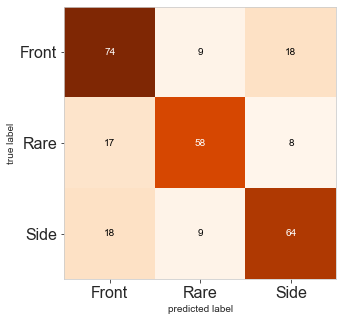

In [103]:
#confusion matrix
confmatrix  = metrics.confusion_matrix(testLabels, rf_modelpred)
plt.figure()
plot_confusion_matrix(confmatrix,figsize=(8,5), hide_ticks=True,cmap=plt.cm.Oranges)
plt.xticks(range(3), ['Front','Rare','Side'], fontsize=16)
plt.yticks(range(3), ['Front','Rare','Side'], fontsize=16)
plt.show()

**Model Test**

Now we predict some downloaded images using our model

**Load RF Model**

In [104]:
#load model
classifier = pk.load(open(config2['classifier_path'], 'rb'))

#read,preprocess and classify image
def damaged_location(image_path):    
    img = load_img(image_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    location_check1 = ['Front Damage', 'Rare Damage', 'Side Damage']
    return location_check1[preds[0]]

In [105]:
classifier

RandomForestClassifier(random_state=0)

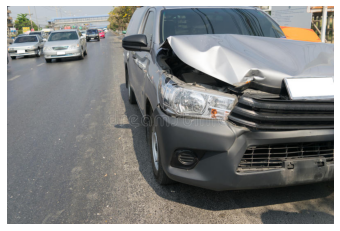

In [106]:
#front damaged car
display_img('C:/Users/Admin/image10.jpg')

In [107]:
#prediction
damaged_location('C:/Users/Admin/image10.jpg')

1/1 [==============================] - 0s 262ms/step


'Front Damage'

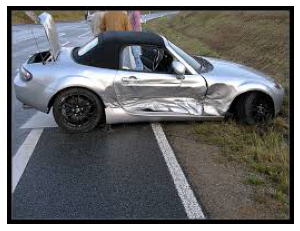

In [108]:
#side damaged car
display_img('C:/Users/Admin/side.jpeg')

In [109]:
#prediction
damaged_location('C:/Users/Admin/side.jpeg')

1/1 [==============================] - 0s 261ms/step


'Side Damage'

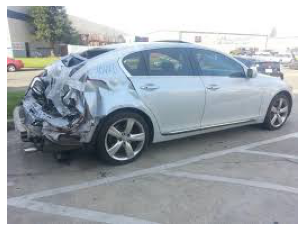

In [110]:
#side damaged car
display_img('C:/Users/Admin/rare.jpg')

In [111]:
damaged_location('C:/Users/Admin/rare.jpg')

1/1 [==============================] - 0s 249ms/step


'Rare Damage'

## 4.0 Fourth Check - Damage Severity

For this last check, we will be building a random forest classifier model that can detect if the car damage is minor, moderate or sever. We will be extracting features with Vgg16, using the previous procedures.

### 4.1 Load and Explore Data

In [112]:
train_minor_path ='C:/Users/Admin/carSEVERITYdata/training/01-minor/'
train_mod_path ='C:/Users/Admin/carSEVERITYdata/training/02-moderate/'
train_sev_path ='C:/Users/Admin/carSEVERITYdata/training/03-severe/'
lbl_dir2 = 'C:/Users/Admin/carSEVERITYdata/training/'
lbl = os.listdir(lbl_dir2)
def display_samples3(number, label):
    plt.figure(figsize=(10,10))
    if label == 'minor':
        for i in range(number):
            minor_img = os.listdir(train_minor_path)[i]
            minor_img_address = train_minor_path+minor_img
            minor_load = Image.open(minor_img_address)
            minor_resize = minor_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.tight_layout()
            plt.imshow(minor_resize)
            plt.title('Minor Damage')
    elif label == 'moderate':
        for i in range(number):
            mod_img = os.listdir(train_mod_path)[i]
            mod_img_address = train_mod_path+mod_img
            mod_load = Image.open(mod_img_address)
            mod_resize = mod_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.imshow(mod_resize)
            plt.title('Moderate Damage')
    else:
        for i in range(number):
            sev_img = os.listdir(train_sev_path)[i]
            sev_img_address = train_sev_path+sev_img
            sev_load = Image.open(sev_img_address)
            sev_resize = sev_load.resize((250, 200))
            ax = plt.subplot(int(number/2),int(number/2),i+1)
            plt.axis('off')
            plt.imshow(sev_resize)
            plt.title('Severe Damage')
    plt.axis('off')

**Sample Images**

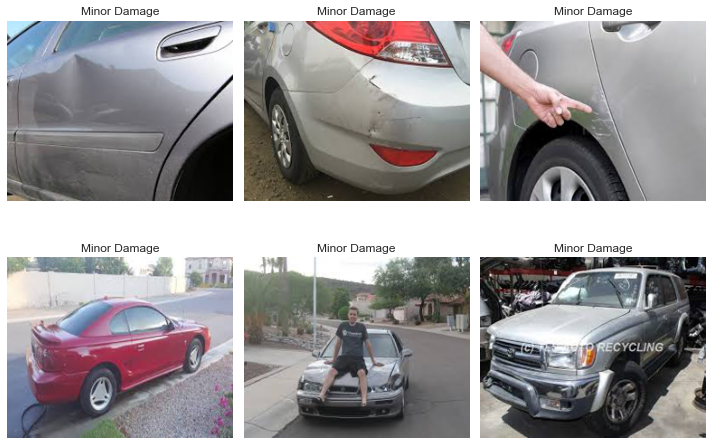

In [113]:
#display sample minor damage
display_samples3(6, label='minor')

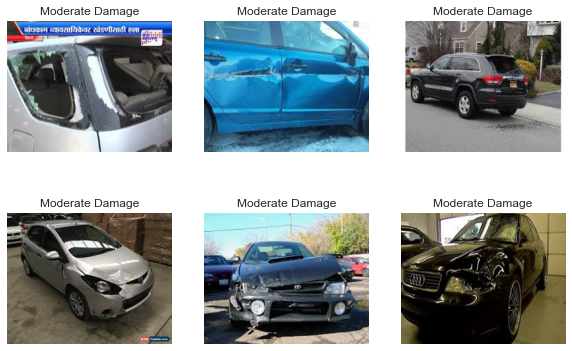

In [114]:
#display sample moderate damage
display_samples3(6, label='moderate')

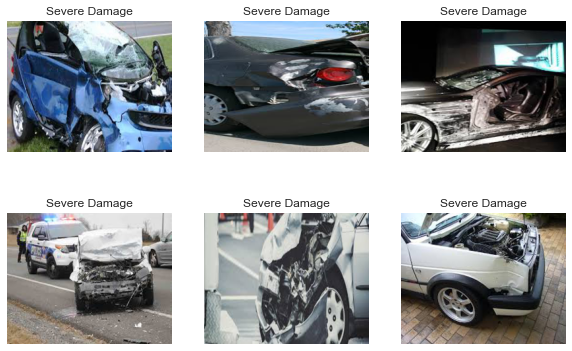

In [115]:
#display sample severe damage
display_samples3(6, label='severe')

**Bar Plot**

Total Number of Images: 1116
Number of Minor damaged Car Images : 363
Number of Moderate damaged Car Images: 369
Number of Severe damaged Car Images: 384


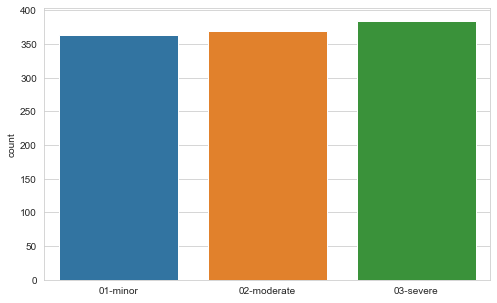

In [116]:
bar_plot(lbl_dir2)

print('Number of Minor damaged Car Images :', len(os.listdir(train_minor_path)))
print('Number of Moderate damaged Car Images:', len(os.listdir(train_mod_path)))
print('Number of Severe damaged Car Images:', len(os.listdir(train_sev_path)))

**Variable Declaration**

In [117]:
config3 = {
    'model': 'vgg16',
    'weights': 'imagenet',
    'include_top': False,
    'train_path': 'C:/Users/Admin/carSEVERITYdata/training',
    'test_path': 'C:/Users/Admin/carSEVERITYdata/test',
    'features_path': 'C:/Users/Admin/car-severity-params/features.h5',
    'labels_path': 'C:/Users/Admin/car-severity-params/labels.h5',
    'results': 'C:/Users/Admin/car-severity-params/results.txt',
    'classifier_path': 'C:/Users/Admin/car-severity-params/classifier.pickle',
    'model_path': 'C:/Users/Admin/car-severity-params/model',
    'test_size': 0.20,
    'seed': 9
}

In [118]:
model_name = config3['model']
weights = config3['weights']
include_top = config3['include_top']
train_path = config3['train_path']
features_path = config3['features_path']
labels_path = config3['labels_path']
results = config3['results']
model_path = config3['model_path']
test_size = config3['test_size']
classifier_path = config3['classifier_path']
seed = config3['seed']

In [119]:
warnings.simplefilter(action='ignore', category=FutureWarning)

if model_name == 'vgg16':
    base_model = VGG16(weights=weights)
    model = Model(base_model.input, base_model.get_layer('fc1').output) #get the 16 conv layers and full conv layer 1
    image_size = (224, 224)
else:
    model = None
print('Successfully loaded base model and model')

Successfully loaded base model and model


**Feature Extraction**

In [120]:
train_labels = os.listdir(train_path)

le = LabelEncoder()
le.fit([t1 for t1 in train_labels])

features = []
labels = []

count = 1

for i, label in enumerate(train_labels):
    cur_path = train_path + '/' + label
    count = 1
    for image_path in glob.glob(cur_path + '/*.jpg'):
        img = load_img(image_path, target_size = image_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        clear_output(wait=True)
    print('Completed label - '+ label)

#Encode labels
le = LabelEncoder()
le_labels = le.fit_transform(labels)

Completed label - 03-severe


**Save Features and Labels**

In [121]:
#save extracted features and labels

h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_3', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_3', data=np.array(le_labels))
h5f_data.close()
h5f_label.close()

#save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + '.json', 'w') as json_file:
    json_file.write(model_json)
    
#save weights
model.save_weights(model_path + str(test_size) + '.h5')
print('Features, Labels, Model and Weights saved..')

end = time.time()
#print('End time - {}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M')))

Features, Labels, Model and Weights saved..


### 4.2 Random Forest

In [122]:
#load features and labels
h5f_data = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_3']
labels_string = h5f_label['dataset_3']

features = np.array(features_string)
labels = np.array(labels_string)
h5f_data.close()
h5f_data.close()

In [123]:
#split data to train and test

(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                 np.array(labels),
                                                                 test_size=test_size,
                                                                 random_state=seed)

print('Training Data images: {}'.format(trainData.shape[0]))
print('Testing Data images: {}'.format(testData.shape[0]))
print('*'*30)
print('Training Labels: {}'.format(trainLabels.shape[0]))
print('Testing Labels: {}'.format(testLabels.shape[0]))

Training Data images: 892
Testing Data images: 223
******************************
Training Labels: 892
Testing Labels: 223


In [124]:
#train model
rf_model2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=0))
rf_model2.fit(trainData, trainLabels)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=0))

In [125]:
#test model
rf_modelpred2 = rf_model2.predict(testData)

In [126]:
#model evaluation
accuracy = metrics.accuracy_score(testLabels, rf_modelpred2)
print('Accuracy: ', accuracy)

Accuracy:  0.6502242152466368


In [127]:
print(metrics.classification_report(testLabels, rf_modelpred2))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68        74
           1       0.51      0.47      0.49        73
           2       0.71      0.83      0.76        76

    accuracy                           0.65       223
   macro avg       0.64      0.65      0.64       223
weighted avg       0.65      0.65      0.65       223



<Figure size 432x288 with 0 Axes>

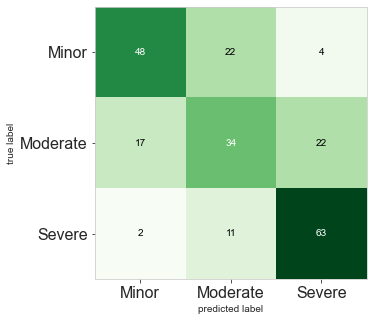

In [128]:
#confusion matrix
confmatrix  = metrics.confusion_matrix(testLabels, rf_modelpred2)
plt.figure()
plot_confusion_matrix(confmatrix,figsize=(8,5), hide_ticks=True,cmap=plt.cm.Greens)
plt.xticks(range(3), ['Minor','Moderate','Severe'], fontsize=16)
plt.yticks(range(3), ['Minor','Moderate','Severe'], fontsize=16)
plt.show()

In [129]:
#save model
pk.dump(rf_model2, open(classifier_path, 'wb'))

**Model Test**

Now we predict some downloaded images using our model

**Load RF Model**

In [130]:
classifier = pk.load(open(config3['classifier_path'], 'rb'))

#read,preprocess and classify image
def damage_severity(image_path):    
    img = load_img(image_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    severity_check1 = ['Minor Damage', 'Moderate Damage', 'Severe Damage']
    return severity_check1[preds[0]]

Image 1

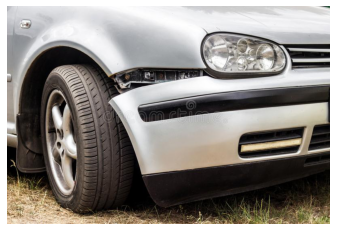

In [131]:
display_img('C:/Users/Admin/image20.jpg')

In [132]:
damage_severity('C:/Users/Admin/image20.jpg')

1/1 [==============================] - 0s 290ms/step


'Moderate Damage'

Image 2

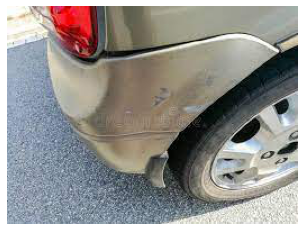

In [133]:
#severe damaged car
display_img('C:/Users/Admin/image21.jfif')

In [134]:
damage_severity('C:/Users/Admin/image21.jfif')

1/1 [==============================] - 0s 270ms/step


'Minor Damage'

Predict Image 3

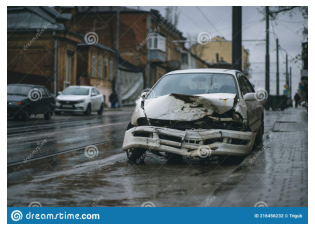

In [135]:
display_img('C:/Users/Admin/image22.jpg')

In [136]:
damage_severity('C:/Users/Admin/image22.jpg')

1/1 [==============================] - 0s 197ms/step


'Severe Damage'

## 5.0 Intergrate All Models

In this part, we will now combine all four models in a single code to screen images through four different checks. 

- The first check uses vgg16 to check if the image is of a car or not, if its a car; it passes to 

- The second check which uses logistic regression to check if the car is damaged or not, if damaged; it passes to 

- The third check which uses random forest to check for the damaged side of the car 

- The fourth checks for the severity of the damage using random forest.

### 5.0.1 Load all Models

In [137]:
#load models
first_check = VGG16(weights='imagenet')
second_check = pk.load(open('C:/Users/Admin/car-damage-params/classifier.pickle', 'rb'))
third_check = pk.load(open('C:/Users/Admin/car-FRS-params/classifier.pickle', 'rb'))
fourth_check = pk.load(open('C:/Users/Admin/car-severity-params/classifier.pickle', 'rb'))

#load labels for identifying cars using VGG16
with open('label_counter.pk', 'rb') as f:
    label_counter = pk.load(f)

In [138]:
#top 25 labels identified by VGG16
label_list = [i for i,j in label_counter.most_common()[:25]]

In [139]:
label_list[:10]

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n03594945', 'jeep'),
 ('n03769881', 'minibus'),
 ('n04461696', 'tow_truck')]

### First Check - Car or Not

In [140]:
#load labels with the highest probabilities
class_index = None
class_index_path = 'C:/Users/Admin/imagenet_class_index.json'

def get_predictions(preds,top=5):
    global class_index
    
    #load json file
    class_index = json.load(open(class_index_path))
    
    #top5 predictions
    results = []
    for i in preds:
        top_five = i.argsort()[-top:][::-1]
        result = [tuple(class_index[str(x)]) + (i[x],) for x in top_five]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


In [141]:
#Function to preprocess image in a format acceptable by VGG16
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [142]:
def check_car_or_not(img_224, model):
    print('Validating if the picture is of a Car...\n')
    #img = preprocess_image(image_path)
    out = model.predict(img_224)
    top = get_predictions(out, top=5)
    for j in top[0]:
        if j[0:2] in label_list:
            print('\n=>> Car Check Passed!!!')
            print('\n')
            return True
    return False

### Second Check - Damaged or Not

In [143]:
def check_damaged_or_not(classifier):
    print('Validating if there is Damage...\n')
    train_labels = ['Car is Damaged', 'Car is not Damaged']
    base_model = first_check
    
    model = Model(base_model.input, base_model.get_layer('fc1').output)
    image_size = (224, 224)
    img = load_img(image_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    prediction = train_labels[preds[0]]
    
    if train_labels[preds[0]] == 'Car is Damaged':
        print('\n=>> Damage Check Passed!!! - Proceeding to damage location and severity detection\n')
        return True
    else:
        return False
    

### Third Check - damage location

In [144]:
def check_damaged_location(classifier):
    print('Validating Damage location...\n')
    train_labels = ['Front', 'Rare-Side']
    base_model = first_check
    
    model = Model(base_model.input, base_model.get_layer('fc1').output)
    image_size = (224, 224)
    img = load_img(image_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    prediction = train_labels[preds[0]]
    print('\n~Your car is damaged at the ', train_labels[preds[0]])
    print('\n')
    print('=>> Damage location Passed!!! - Proceeding to severity detection\n')

### Fourth Check - Severity

In [145]:
def check_damaged_severity(classifier):
    print('Validating the severity of the Damage...\n')
    train_labels = ['Minor', 'Moderate', 'Severe']
    base_model = first_check
    
    model = Model(base_model.input, base_model.get_layer('fc1').output)
    image_size = (224, 224)
    img = load_img(image_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    prediction = train_labels[preds[0]]
    print('\n~Your car Damage is ', train_labels[preds[0]])
    print('\n=>>All Checks complete')
    print('\nThank you for using this service.')

### 5.0.2 All Checks 

The function takes an image, preprocess the image and passes it through each checks.

In [146]:
def all_checks(img):
    while True:
        try:
            img_224 = preprocess_image(img)
            ch1 = check_car_or_not(img_224, first_check)
            
            if ch1 is False:
                print('\nImage does not look like a picture of a car, please submit another picture of your damaged car.')
                print('\nHint: Try zooming in/out, using a different angle or lighting.')
                break
                
            ch2 = check_damaged_or_not(classifier=second_check)
            
            if ch2 is False:
                print('\nAre you sure this car is damaged? Please submit another picture of your damaged car.')
                print('\nHint: Try zooming in/out, using a different angle or lighting.')
                break
                
            ch3 = check_damaged_location(classifier=third_check)
            ch4 = check_damaged_severity(classifier=fourth_check)
            break
        except:
            print('Image not processable. Please try again.')
            break
                
                      

## 5.1 Predictions

Now that all checks has been combined, we will now test our system with a non-car image, non-damaged car image and a damaged car image.

### 5.1.0 Prediction with a non-car image

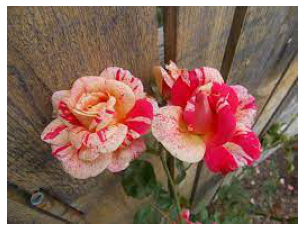

In [147]:
display_img('C:/Users/Admin/image1.jfif')

In [148]:
image_path = 'C:/Users/Admin/image1.jfif'
all_checks(image_path)

Validating if the picture is of a Car...

1/1 [==============================] - 0s 367ms/step

Image does not look like a picture of a car, please submit another picture of your damaged car.

Hint: Try zooming in/out, using a different angle or lighting.


### 5.1.1 Prediction with a non-damaged car

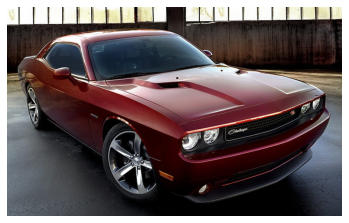

In [149]:
display_img('C:/Users/Admin/Normal.jpg')

In [150]:
image_path = 'C:/Users/Admin/Normal.jpg'
all_checks(image_path)

Validating if the picture is of a Car...

1/1 [==============================] - 0s 254ms/step

=>> Car Check Passed!!!


Validating if there is Damage...

1/1 [==============================] - 0s 495ms/step

Are you sure this car is damaged? Please submit another picture of your damaged car.

Hint: Try zooming in/out, using a different angle or lighting.


### 5.1.2 Prediction with a damaged car

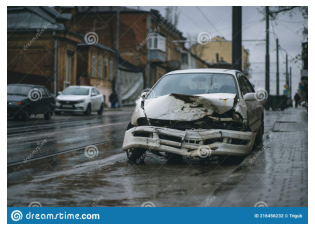

In [151]:
display_img('C:/Users/Admin/image22.jpg')

In [153]:
warnings.simplefilter(action='ignore', category=FutureWarning)
image_path = 'C:/Users/Admin/image22.jpg'
all_checks(image_path)

Validating if the picture is of a Car...

1/1 [==============================] - 0s 280ms/step

=>> Car Check Passed!!!


Validating if there is Damage...

1/1 [==============================] - 0s 493ms/step

=>> Damage Check Passed!!! - Proceeding to damage location and severity detection

Validating Damage location...

1/1 [==============================] - 1s 533ms/step

~Your car is damaged at the  Front


=>> Damage location Passed!!! - Proceeding to severity detection

Validating the severity of the Damage...

1/1 [==============================] - 0s 454ms/step

~Your car Damage is  Severe

=>>All Checks complete

Thank you for using this service.


## Appendix


In [ ]:
# magick mogrify -format jpg -quality 100 *.png

In [247]:
#downloader.download('moderate car damage', limit=100, output_dir='imgdwnld')